In [1]:
import numpy as np
from scipy.integrate import simpson as simps
import matplotlib.pyplot as plt  
import scipy.constants as cst
from IPython.display import display, Math

In [2]:
# Fonction intégration

def cumulative_trapezoid(y, x):
    """
    Primitive cumulative de y(x) : returns array Y where
    Y[i] = integral from x[0] to x[i] of y(x) dx
    Méthode des trapèzes, pure numpy.
    """
    dx = np.diff(x) # largeur des trapèzes
    # trap area on each interval
    areas = 0.5 * (y[:-1] + y[1:]) * dx #calcul de l'air d'un trapèze # moyenne des trapèzes * largeur = Aire
    #concatenate de 0 pour avoir 0 en première intégrale ( quand r=0)
    return np.concatenate(([0.0], np.cumsum(areas))) #cumsum fait la somme cumulative des aires définies plus tôt. ([A0, A0+A1...])

def nested_integral(r, rho_r, P_r, r_star_index=None, cst_=1.0):
    """
    Calcule P* = cst * ∫_0^{r*} P(r) * r * [ ∫_0^{r} rho(r') r'^2 dr' ] dr
    - r : array des rayons (strictement croissant), r[0] doit être 0 (ou proche).
    - rho_r : rho(r) évalué sur la grille r
    - P_r : P(r) évalué sur la grille r
    - r_star_index : index i tel que r[i] = r* (si None, on prend r[-1])
    - cst : constante multiplicative
    Retourne (Pstar, inner_cumulative_array, outer_integrand_array)
    """
    #si rayon max est non on prend le bout de la variable d'intégration ( rayon de l'étoile )
    if r_star_index is None:
        r_star_index = len(r) - 1

    # si tableaux pas de la même taille retourne assertionerror
    r = np.asarray(r)
    rho_r = np.asarray(rho_r)
    P_r = np.asarray(P_r)
    assert r.shape == rho_r.shape == P_r.shape

    # calcul de f(r) = rho(r) * r^2
    f = rho_r * (r**2)

    # primitive I(r) = int_0^r f(r') dr'
    #ici on calcul la primitive en chaque point et on l'intégre ensuite
    I = cumulative_trapezoid(f, r)

    # intégrande extérieur g(r) = P(r) * r * I(r)
    #pour P* #the factor 3 comes from the fact that T^i_i = 3P
    g =  3 * P_r * r * I
    #Pour E*
    h = rho_r * r * I

    # intégration doit être faite jusqu'au bord de l'étoile
    r_cut = r[:r_star_index+1]
    g_cut = g[:r_star_index+1]
    h_cut = h[:r_star_index+1]

    # intégrale extérieure par trapèzes
    #ici on mène l'intégration
    outer_integral_Pstar = simps(g_cut, r_cut)
    outer_integral_Estar = simps(h_cut, r_cut)

    #Pstar = cst * outer_integral
    Pstar_incomplete = cst_ * outer_integral_Pstar
    Estar_incomplete = cst_ * outer_integral_Estar
    
    return Pstar_incomplete,Estar_incomplete, I, g


## Case of the Sun

In [3]:
SUN_model = np.genfromtxt('Sun_profile', comments = '#') # Everything is in SI (https://users-phys.au.dk/jcd/solar_models/)

#Christensen-Dalsgaard, J., Däppen, W., Ajukov, S. V., Anderson, E. R., Antia, H. M., Basu, S., Baturin, V. A., Berthomieu, G., Chaboyer, B., Chitre, S. M., Cox, A. N., Demarque, P., Donatowicz, J., Dziembowski, W. A., Gabriel, M., Gough, D. O., Guenther, D. B., Guzik, J. A., Harvey, J. W., Hill, F., Houdek, G., Iglesias, C. A., Kosovichev, A. G., Leibacher, J. W., Morel, P., Proffitt, C. R., Provost, J., Reiter, J., Rhodes Jr., E. J., Rogers, F. J., Roxburgh, I. W., Thompson, M. J., Ulrich, R. K., 1996.
#The current state of solar modeling.
#Science, 272, 1286 - 1292. 

In [4]:
PSUN_center_bar = 2.477e11 # (bar) https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html (hereafter referred to as 'NASA')
rhoSUN_center = 1.622e5 # kg/m^3 https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html

barTOpascal = 1e5

PSUN_center = PSUN_center_bar * barTOpascal # pascal

print(f'For the sun, at the center, the ratio between the pressure and density is {PSUN_center / (rhoSUN_center*cst.c**2)}')

For the sun, at the center, the ratio between the pressure and density is 1.699157946266839e-06


In [5]:
SUN_radius = 695700*1e3 # m https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
# Density
Density_SUN = SUN_model[:,2] * 1e-3 / (1e-2)**3 # kg/m^3
# Pressure
Pressure_SUN = SUN_model[:,3] / 10 # pascal (bc, given in dyn/cm^2)
# Radius of the Sun
Radius_SUN =  SUN_model[:,0] * SUN_radius


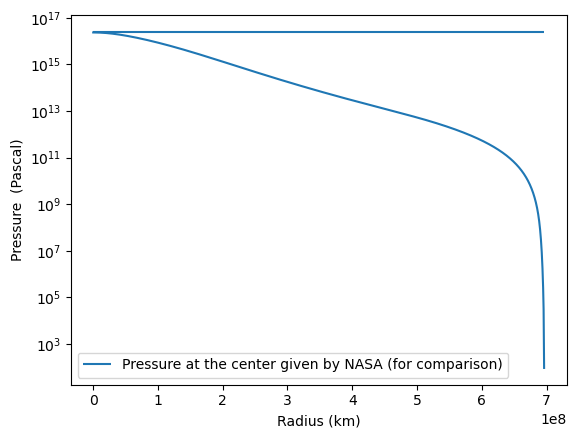

In [6]:
img, ax = plt.subplots()
ax.plot(Radius_SUN,Pressure_SUN) 
ax.hlines(y = PSUN_center, xmin = 0 , xmax = SUN_radius , label = 'Pressure at the center given by NASA (for comparison)')
ax.set_yscale('log')
plt.xlabel('Radius (km)')
plt.ylabel('Pressure  (Pascal)')
plt.legend()
plt.show()

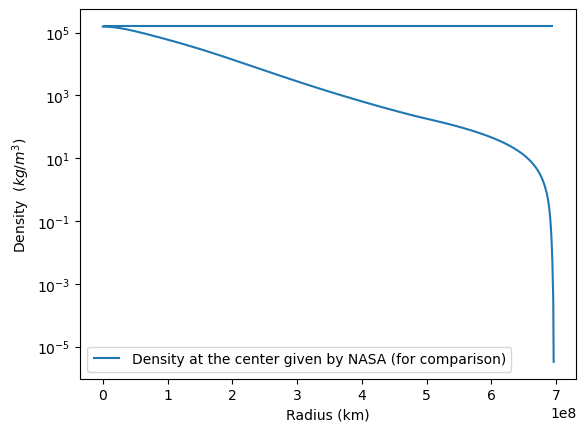

In [7]:
img, ax = plt.subplots()
ax.plot(Radius_SUN,Density_SUN) 
ax.hlines(y = rhoSUN_center, xmin = 0 , xmax = SUN_radius , label = 'Density at the center given by NASA (for comparison)')
ax.set_yscale('log')
plt.xlabel('Radius (km)')
plt.ylabel('Density  ($kg/m^3$)')
plt.legend()
plt.show()

In [8]:
kappa_tilde = 8 * np.pi * cst.G/cst.c**4
phi_0 = 1

In [9]:
R = SUN_radius  
N = 2482
#r = np.linspace(0, R, N)
r = Radius_SUN
rho_r = Density_SUN
P_r = Pressure_SUN
constant = kappa_tilde**2/3 * cst.c**2 * np.sqrt(phi_0)
Pstar_incomplete,Estar_incomplete, I_array, g_array = nested_integral(r, rho_r, P_r, r_star_index=None, cst_=constant)

Pstar = kappa_tilde * ( simps(Pressure_SUN * np.sqrt(phi_0) * Radius_SUN**2, -Radius_SUN)) + Pstar_incomplete
Estar = kappa_tilde/3 * ( simps(Density_SUN * np.sqrt(phi_0) * Radius_SUN**2, -Radius_SUN)) + Estar_incomplete

print("P* =", Pstar)
print("E* =", Estar)

P* = 0.0033676895833227587
E* = 1.0942899074405083e-14


In [10]:
theta = 3 * Pstar/(Estar*cst.c**2)
gamma = (1+2 *theta+1/2)/(2+theta-1/2)
display(Math(r"\gamma - 1 = {:.0e}".format(gamma - 1)))

<IPython.core.display.Math object>

In [11]:
delta_Sun = 4/3 * ( gamma**2 - 1/4 * ( (3+2 * theta)/(np.sqrt(9 * (1+theta)**2 + 3 * theta**2))  )**(-2) )
display(Math(r"\delta - 1 = {:.0e}".format(delta_Sun - 1))) 

<IPython.core.display.Math object>

## Case of the Earth

In [12]:
PREM_model = np.genfromtxt('densite_pression', comments = '#') # Everything is in SI
#Data provided by Yanick Ricard from the ENS Lyon, but is also available at https://ds.iris.edu/ds/products/emc-prem/

In [13]:
# Density
Density_Earth = PREM_model[:,1]
# Pressure
Pressure_Earth = PREM_model[:,2][-1]- PREM_model[:,2]
# Radius of the Earth
Earth_radius  = PREM_model[:,0][-1]
Radius_Earth = PREM_model[:,0] 

In [14]:
dr = PREM_model[:,0][1]-PREM_model[:,0][0]

In [15]:
R = Earth_radius  
N = 2482
r = Radius_Earth
rho_r = Density_Earth
P_r = Pressure_Earth
constant = kappa_tilde**2/3 * cst.c**2 * np.sqrt(phi_0)
Pstar_Earth_incomplete,Estar_Earth_incomplete, I_array, g_array = nested_integral(r, rho_r, P_r, r_star_index=None, cst_=constant)

Pstar_Earth = kappa_tilde * (simps(Pressure_Earth * Radius_Earth**2, -Radius_Earth)) + Pstar_Earth_incomplete
Estar_Earth = kappa_tilde/3 * (simps(Density_Earth * Radius_Earth**2, -Radius_Earth)) + Estar_Earth_incomplete
print("P* =", Pstar_Earth)
print("E* =", Estar_Earth)

P* = -1.3467801230177294e-12
E* = -3.18228720236893e-20


In [16]:
theta_Earth = 3 * Pstar_Earth/(Estar_Earth*cst.c**2)
gamma_Earth = (1+2 *theta_Earth+1/2)/(2+theta_Earth-1/2)
display(Math(r"\gamma - 1 = {:.0e}".format(gamma_Earth - 1)))

<IPython.core.display.Math object>

In [17]:
delta_Earth = 4/3 * ( gamma_Earth**2 - 1/4 * ( (3+2 * theta_Earth)/(np.sqrt(9 * (1+theta_Earth)**2 + 3 * theta_Earth**2))  )**(-2) )
display(Math(r"\delta - 1 = {:.0e}".format(delta_Earth - 1))) 

<IPython.core.display.Math object>